In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [5]:
from models.deepclean import DeepCleanAE, FFTDeepCleanAE
from signal_gen.generate_signal import build_empty_signal, gauss_sig
from signal_gen.colored_noise import add_noise_to_signal
import matplotlib.pyplot as plt
from models.base_dense import BaselineDense

In [6]:
from scipy import signal

n = 1000
sr = 1000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3

def build_empty_signal(n, sr):
    t = np.arange(n) / sr
    x = np.zeros(n)
    return x, t

def gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    signal_length = len(x)
    
    for _ in range(num_pulses):
        std = np.random.uniform(std_min, std_max)
        amp = np.random.uniform(amp_min, amp_max)
        
        window_length = int(2 * std_length * std)  # Ensure the window length is odd
        if window_length % 2 == 1: window_length -= 1
                
        window = signal.windows.gaussian(window_length, std=std)
        window = amp*window
        
        
        pos = np.random.randint(window_length, signal_length-window_length//2)
        
        start = pos - (window_length // 2) 
        end = pos + (window_length // 2 )
        
        
        window_segment = window[:end - start]  # Adjust the length of the window segment
        x[start:end] += window_segment

        '''
        plt.figure(figsize=(12, 6))
        plt.plot(t, x)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Signal with Gaussian Pulses')
        plt.grid(True)
        plt.show()
        '''

    return x

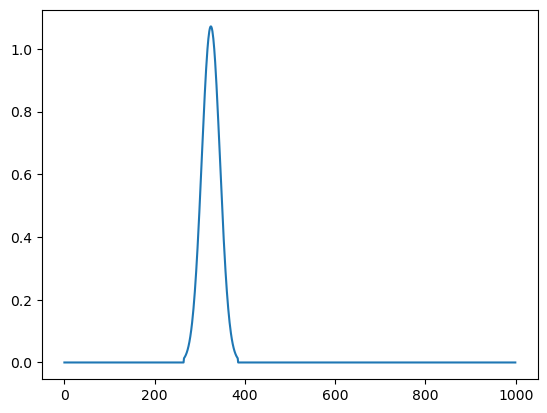

In [7]:
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)

# Generate A Gaussian Pulse

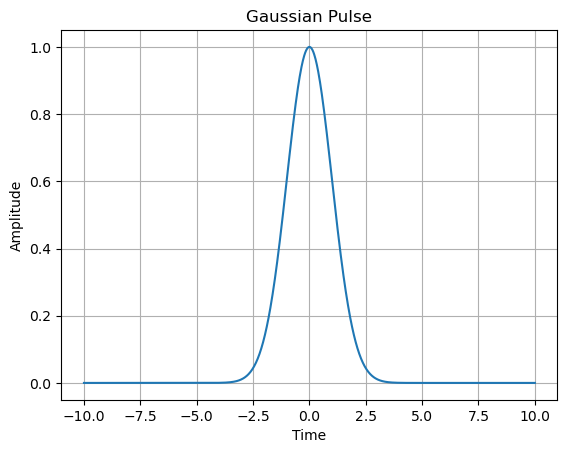

In [8]:
def generate_gaussian_pulse(N):
    # Parameters for the Gaussian pulse
    t = np.linspace(-10, 10, N)  # Time axis
    A = 1.0  # Amplitude
    sigma = 1.0  # Standard deviation (controls the width of the pulse)
    center = 0.0  # Center of the pulse

    # Gaussian pulse equation
    gaussian_pulse = A * np.exp(-(t - center)**2 / (2 * sigma**2))
    return gaussian_pulse

t = np.linspace(-10, 10, 1000)
sample_gaussian_pulse = generate_gaussian_pulse(1000)
# Plot the Gaussian pulse
plt.plot(t, sample_gaussian_pulse)
plt.title('Gaussian Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Generate Colored Noise

In [115]:
def generate_white_noise(N):
    """Generate white noise."""
    return np.random.normal(size=N)

def generate_colored_noise(N, color='white'):
    """Generate colored noise."""
    # Generate white noise
    white_noise = generate_white_noise(N)
    
    # FFT to go to the frequency domain
    f_noise = np.fft.rfft(white_noise)
    
    # Generate the frequency index
    f = np.fft.rfftfreq(N)
    
    # Apply frequency-dependent scaling
    if color == 'pink':
        f_noise = f_noise / (f + 1e-8)  # Avoid division by zero
    elif color == 'brown':
        f_noise = f_noise / (f**2 + 1e-8)
    elif color == 'blue':
        f_noise = f_noise * f
    elif color == 'violet':
        f_noise = f_noise * (f**2)
    
    # Inverse FFT to return to time domain
    colored_noise = np.fft.irfft(f_noise, n=N)
    
    return colored_noise

def generate_noise_freq(N, A, duration, sample_rate, freqs = []):
    
    t = np.linspace(0, duration, int(sample_rate*duration))  # Time axis
    
    noise = np.zeros_like(t)
    for freq in freqs:
        noise += A*np.sin(2*np.pi*freq*t)
    return noise


# # Parameters
# N = 1000  # Number of samples
# color_type = 'brown'  # Choose from 'white', 'pink', 'brown', 'blue', 'violet'

# # Generate colored noise
# colored_noise = generate_colored_noise(N, color=color_type)
# # colored_noise = generate_white_noise(N)

# # Plot the noise
# plt.plot(colored_noise)
# plt.title(f'{color_type.capitalize()} Noise')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.show()

# sample_gaussian_pulse = generate_gaussian_pulse(1000)
# noise = generate_noise_freq(1000, 0.1, [0.1, 0.2])
# plt.plot(noise)
# plt.show()
# plt.plot(sample_gaussian_pulse+noise)


# Generate Dataset with Noise

In [128]:
import random
dataset_size = 1000
sr = 10000
X = []
Y = []
duration = 2
sample_rate = 5000
N = duration * sample_rate
noise_amplitude = 0.3
for i in range(dataset_size):
    freq = random.sample([1,3,5,7,10,12,15,17,20],3)
    x, t = build_empty_signal(N, sr)
    x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
    noise = generate_noise_freq(N, noise_amplitude, duration, sample_rate, freq)
    X.append(x+noise)
    Y.append(noise)
        

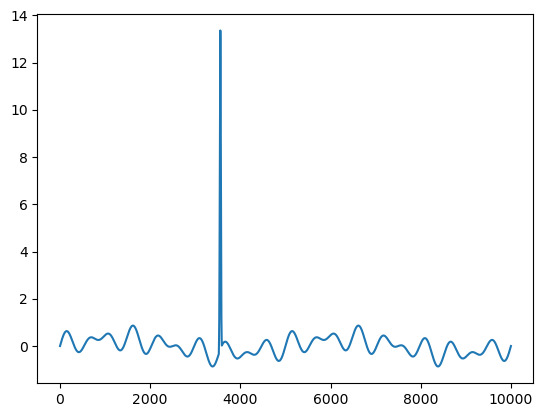

In [129]:
plt.plot(X[0])

In [130]:
X = torch.tensor(X).unsqueeze(dim=1).to(torch.float32)
Y = torch.tensor(Y).to(torch.float32)
print(X.shape)
print(Y.shape)

torch.Size([1000, 1, 10000])
torch.Size([1000, 10000])


# Training Setup

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# dataset generation
batch_size = 16
train_dataset = TensorDataset(X, Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model Instantiation
in_channels = 1
model = FFTDeepCleanAE(in_channels)
# model.load_state_dict(torch.load("deepclean_model.pth"))

data_for_viz = {}

# Loss function and optimizer
criterion = nn.MSELoss()  # Suitable for classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    batch = 0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        if batch == 0:
            data_for_viz[epoch] = {} # data_for_viz.get(epoch, {})
            data_for_viz[epoch]["input"] = inputs.detach().numpy()
            data_for_viz[epoch]["input_encoding"] = model.encodings["input_conv"]
            for name, _, in list(model.downsampler.named_modules())[1:]:
                if "." in name: continue
                data_for_viz[epoch][f"downsample_{name}"] = model.encodings[f"downsample_{name}"]
            for name, _, in list(model.upsampler.named_modules())[1:]:
                if "." in name: continue
                data_for_viz[epoch][f"upsample_{name}"] = model.encodings[f"upsample_{name}"]
            data_for_viz[epoch]["output_conv"] = model.encodings["output_conv"]
        batch += 1   
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()
    
    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.10f}')

Epoch [1/100], Loss: 2.8483824843
Epoch [2/100], Loss: 0.8651305711
Epoch [3/100], Loss: 0.3981352122
Epoch [4/100], Loss: 0.1976310016
Epoch [5/100], Loss: 0.0826121381
Epoch [6/100], Loss: 0.0480047994
Epoch [7/100], Loss: 0.0357555170
Epoch [8/100], Loss: 0.0291885640
Epoch [9/100], Loss: 0.0240885742
Epoch [10/100], Loss: 0.0207764457
Epoch [11/100], Loss: 0.0182195264
Epoch [12/100], Loss: 0.0163934767
Epoch [13/100], Loss: 0.0150572115
Epoch [14/100], Loss: 0.0136878606
Epoch [15/100], Loss: 0.0118407498
Epoch [16/100], Loss: 0.0110421348
Epoch [17/100], Loss: 0.0114303160
Epoch [18/100], Loss: 0.0090082644
Epoch [19/100], Loss: 0.0083848051
Epoch [20/100], Loss: 0.0076512801
Epoch [21/100], Loss: 0.0071884719
Epoch [22/100], Loss: 0.0066543641
Epoch [23/100], Loss: 0.0058251237
Epoch [24/100], Loss: 0.0055441103
Epoch [25/100], Loss: 0.0053152829
Epoch [26/100], Loss: 0.0052211886
Epoch [27/100], Loss: 0.0050359265
Epoch [28/100], Loss: 0.0045927008
Epoch [29/100], Loss: 0.00428

KeyboardInterrupt: 

In [132]:
torch.save(model, 'deepclean_test.pth')
import pickle

# Save the dictionary to a pickle file
with open('deepclean_encodings.pkl', 'wb') as f:
    pickle.dump(data_for_viz, f)

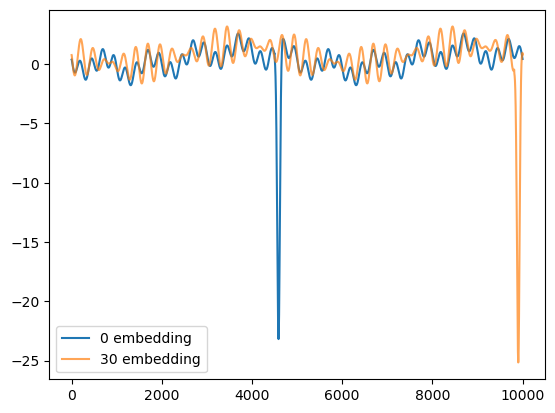

torch.Size([10000])


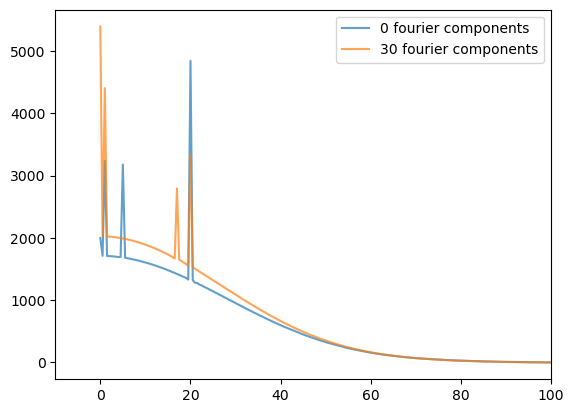

In [163]:
epoch = 0
epoch2 = 30
iev = 6
# plt.plot(data_for_viz[epoch]["input"][iev].squeeze(), label=f"{epoch} signal", alpha=0.7)
plt.plot(data_for_viz[epoch]["input_encoding"][iev].squeeze(), label=f"{epoch} embedding")
plt.plot(data_for_viz[epoch2]["input_encoding"][iev].squeeze(), label=f"{epoch2} embedding", alpha=0.7)
plt.legend()
plt.show()

sample_rate = 5000

# sampling_rate = data_for_viz[epoch]["input_encoding"][iev].squeeze().shape[0]
y = torch.tensor(data_for_viz[epoch]["input_encoding"][iev].squeeze())
y_fft = torch.fft.fft(y)
print(y_fft.shape)
frequencies = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label = f"{epoch} embedding fourier components", alpha=0.7)

# sampling_rate = data_for_viz[epoch2]["input_encoding"][iev].squeeze().shape[0]
y = torch.tensor(data_for_viz[epoch2]["input_encoding"][iev].squeeze())
y_fft = torch.fft.fft(y)
frequencies = torch.fft.fftfreq(len(y), d=1/sample_rate)

plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy(), label=f"{epoch2} embedding fourier components", alpha=0.7)
plt.xlim(-10,100)
plt.legend()
plt.show()

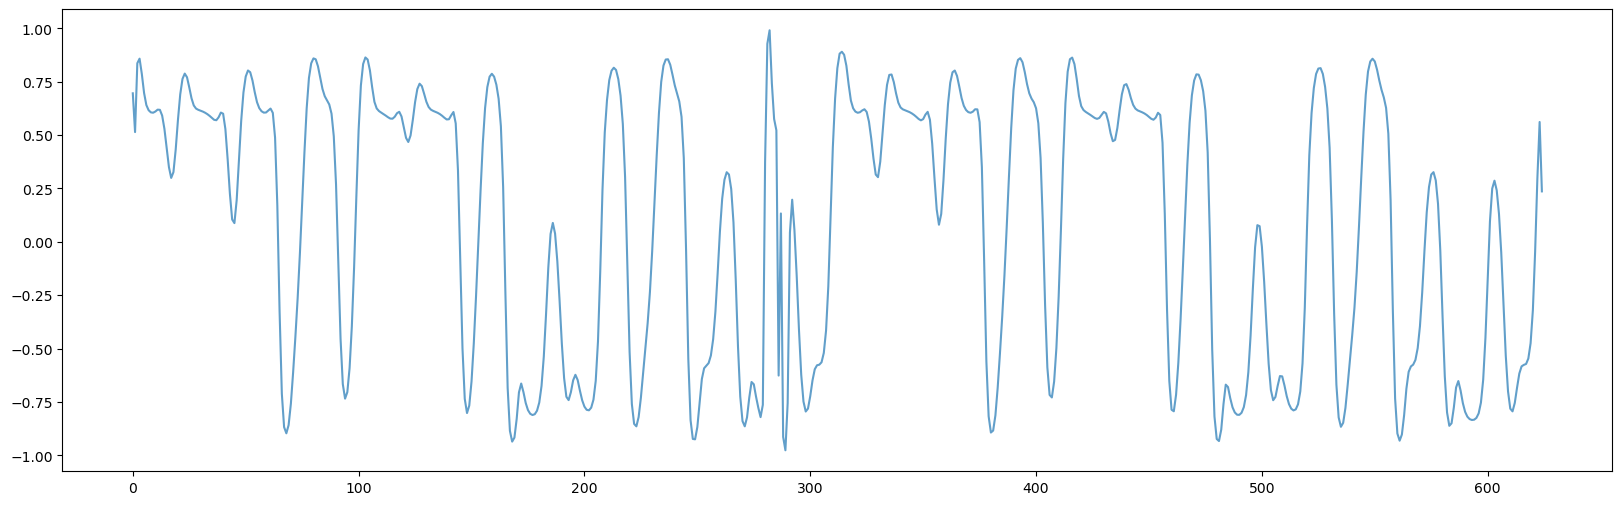

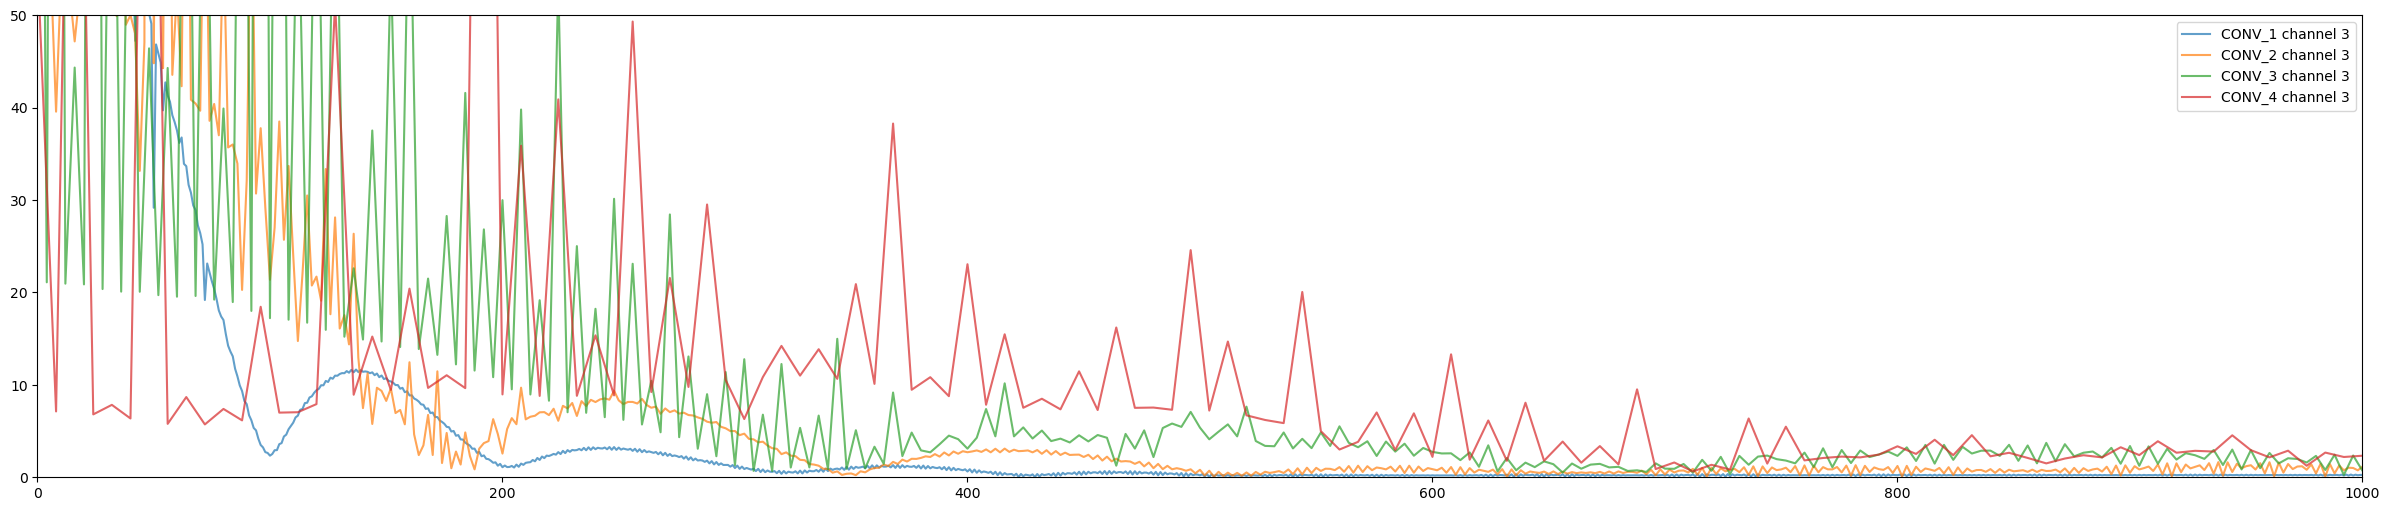

In [187]:
# plt.plot(data_for_viz[0]["downsample"][0][0])
# plt.plot(data_for_viz[0]["downsample"][0][1])
# plt.plot(data_for_viz[0]["downsample"][0][2])
epoch = 30
downsample_layer1 = "CONV_1"
downsample_layer2 = "CONV_2"
downsample_layer3 = "CONV_3"
downsample_layer4 = "CONV_4"
iev = 2
channel = 3
channel2 = 3
channel3 = 3
plt.figure(figsize=(20, 6))
# plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel], alpha=0.7)
# plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer2}"][iev][channel2], alpha=0.7)
# plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel], alpha=0.7)
plt.plot(data_for_viz[epoch][f"downsample_{downsample_layer4}"][iev][channel], alpha=0.7)

plt.show()

plt.figure(figsize=(30, 6))
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel])
y_fft1 = torch.fft.fft(y)
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(y_fft1[:len(y_fft1)//2]).numpy(), label=f"{downsample_layer1} channel {channel}", alpha=0.7)

# sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer2}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer2}"][iev][channel])
y_fft2 = torch.fft.fft(y)
frequencies2 = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies2[:len(frequencies2)//2].numpy(), torch.abs(y_fft2[:len(y_fft2)//2]).numpy(), label=f"{downsample_layer2} channel {channel2}", alpha=0.7)

sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel3].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel3])
y_fft3 = torch.fft.fft(y)
frequencies3 = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies3[:len(frequencies3)//2].numpy(), torch.abs(y_fft3[:len(y_fft3)//2]).numpy(), label=f"{downsample_layer3} channel {channel3}", alpha=0.7)

y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer4}"][iev][channel3])
y_fft3 = torch.fft.fft(y)
frequencies3 = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies3[:len(frequencies3)//2].numpy(), torch.abs(y_fft3[:len(y_fft3)//2]).numpy(), label=f"{downsample_layer4} channel {channel3}", alpha=0.7)

plt.xlim(0,1000)
plt.ylim(0,50)
plt.legend()
plt.show()



In [145]:
print(torch.argmax(torch.abs(y_fft1[:len(y_fft1)//2])))
print(torch.argmax(torch.abs(y_fft2[:len(y_fft2)//2])))
print(torch.argmax(torch.abs(y_fft3[:len(y_fft3)//2])))

tensor(20)
tensor(20)
tensor(20)


torch.Size([5000])
tensor(2)


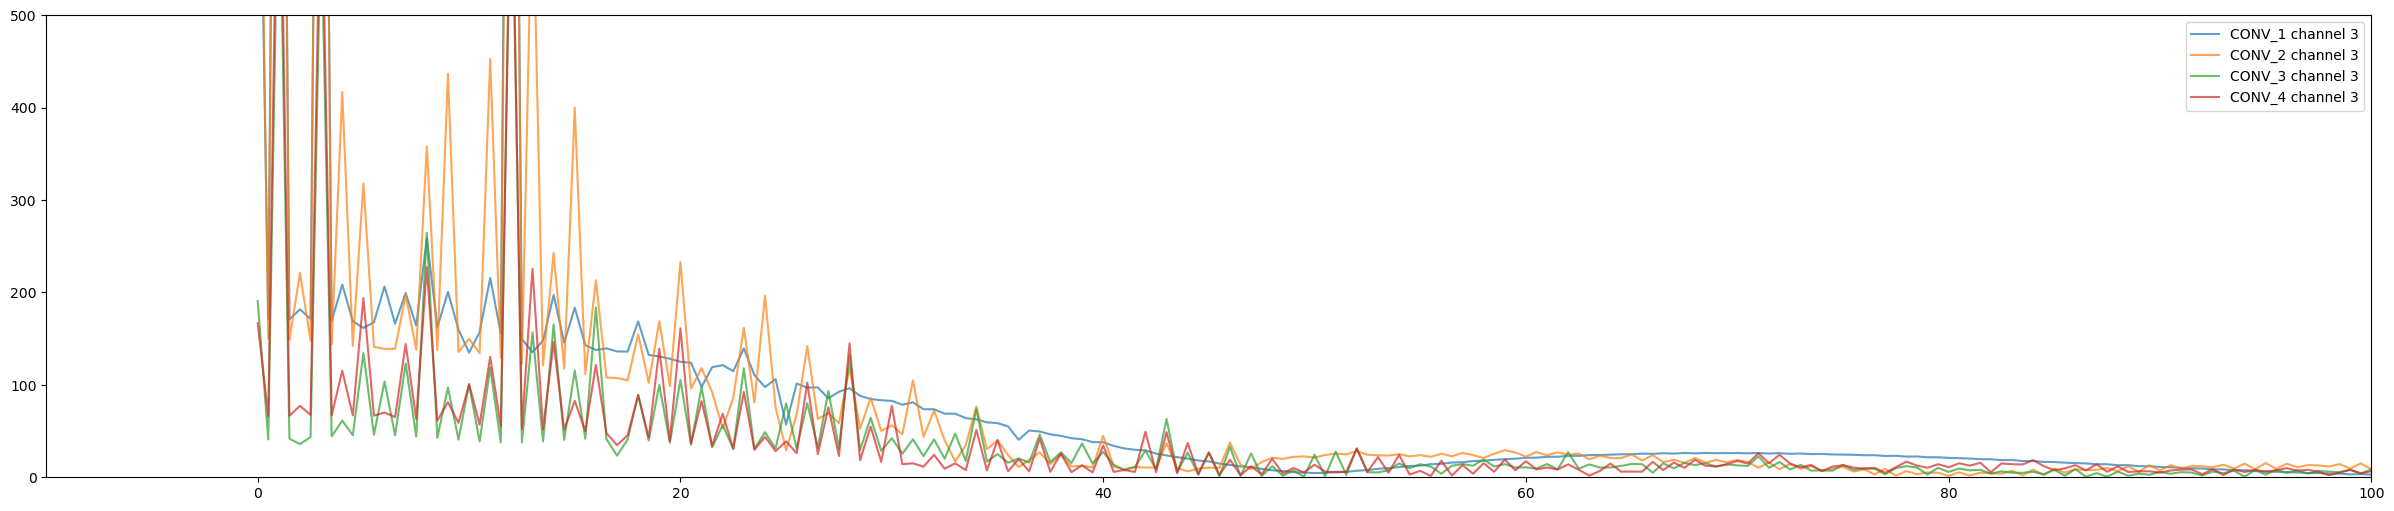

In [206]:
plt.figure(figsize=(30, 6))
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer1}"][iev][channel])
y_fft1 = torch.fft.fft(y)
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate)
print(y_fft1.shape)

downsample_layer3 = "CONV_1"
total_freq = None
for i in range(8):
    y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][i])
    if total_freq is None:
        total_freq = torch.fft.fft(y)
    else:
        total_freq += torch.fft.fft(y)
        
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel].shape[0]
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate*2)

plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(total_freq[:len(total_freq)//2]).numpy(), label=f"{downsample_layer3} channel {channel}", alpha=0.7)

downsample_layer3 = "CONV_2"
total_freq = None
for i in range(16):
    y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][i])
    if total_freq is None:
        total_freq = torch.fft.fft(y)
    else:
        total_freq += torch.fft.fft(y)
        
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel].shape[0]
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate*4)

plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(total_freq[:len(total_freq)//2]).numpy(), label=f"{downsample_layer3} channel {channel}", alpha=0.7)


downsample_layer3 = "CONV_3"
total_freq = None
for i in range(32):
    y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][i])
    if total_freq is None:
        total_freq = torch.fft.fft(y)
    else:
        total_freq += torch.fft.fft(y)
        
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel].shape[0]
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate*8)

plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(total_freq[:len(total_freq)//2]).numpy(), label=f"{downsample_layer3} channel {channel}", alpha=0.7)


downsample_layer3 = "CONV_4"
total_freq = None
for i in range(64):
    y = torch.tensor(data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][i])
    if total_freq is None:
        total_freq = torch.fft.fft(y)
    else:
        total_freq += torch.fft.fft(y)
        
sampling_rate = data_for_viz[epoch][f"downsample_{downsample_layer3}"][iev][channel].shape[0]
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate*16)

plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(total_freq[:len(total_freq)//2]).numpy(), label=f"{downsample_layer3} channel {channel}", alpha=0.7)

plt.xlim(-10,100)
plt.ylim(0,500)
plt.legend()
print(torch.argmax(torch.abs(total_freq[:len(total_freq)//2])))

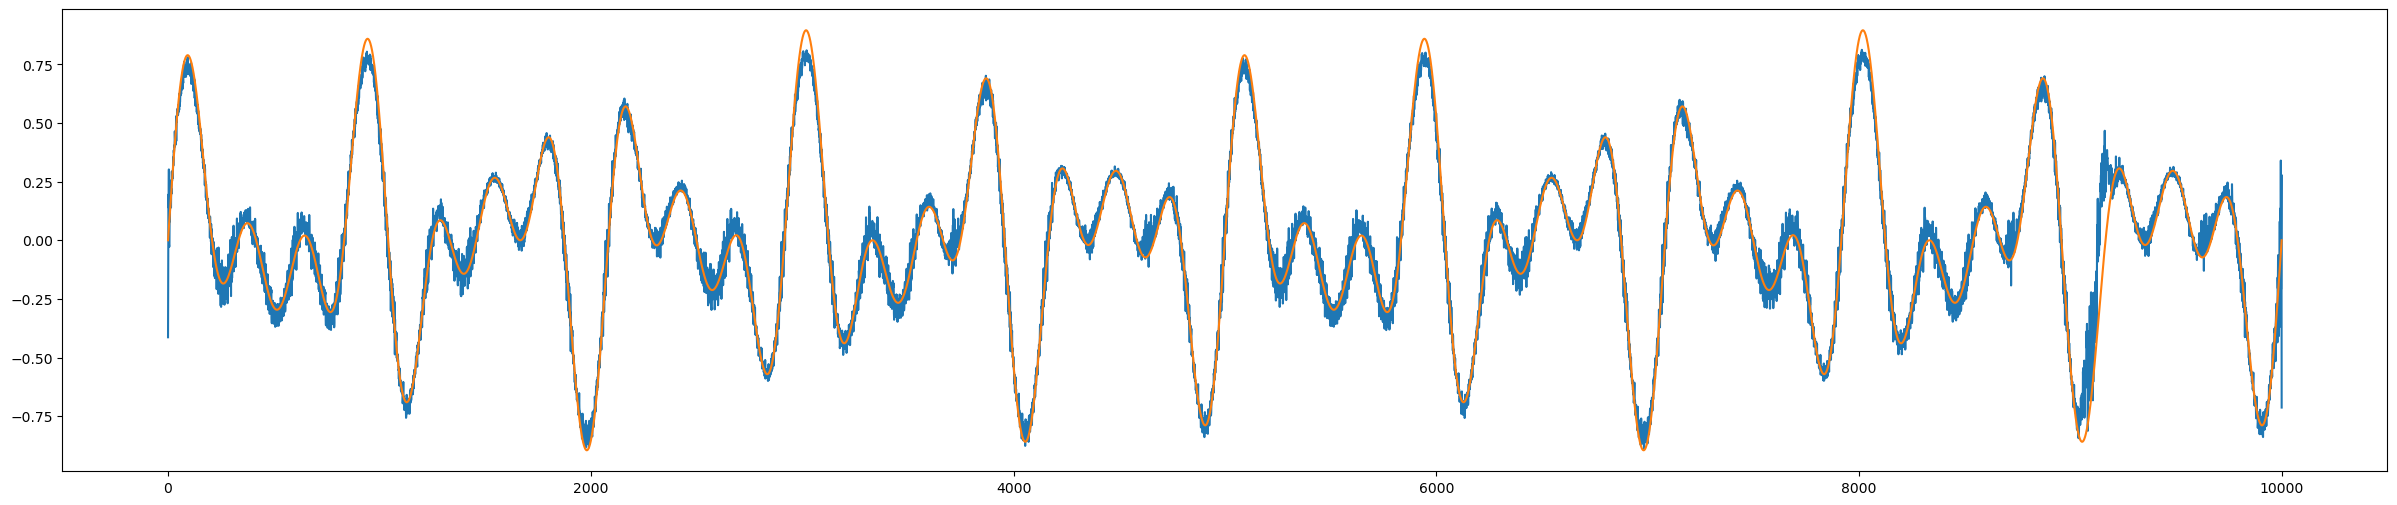

In [149]:
iev = 2
plt.figure(figsize=(30, 6))
plt.plot(outputs[iev].detach().numpy())
plt.plot(labels[iev].detach().numpy())

tensor(20.)
tensor(12.)


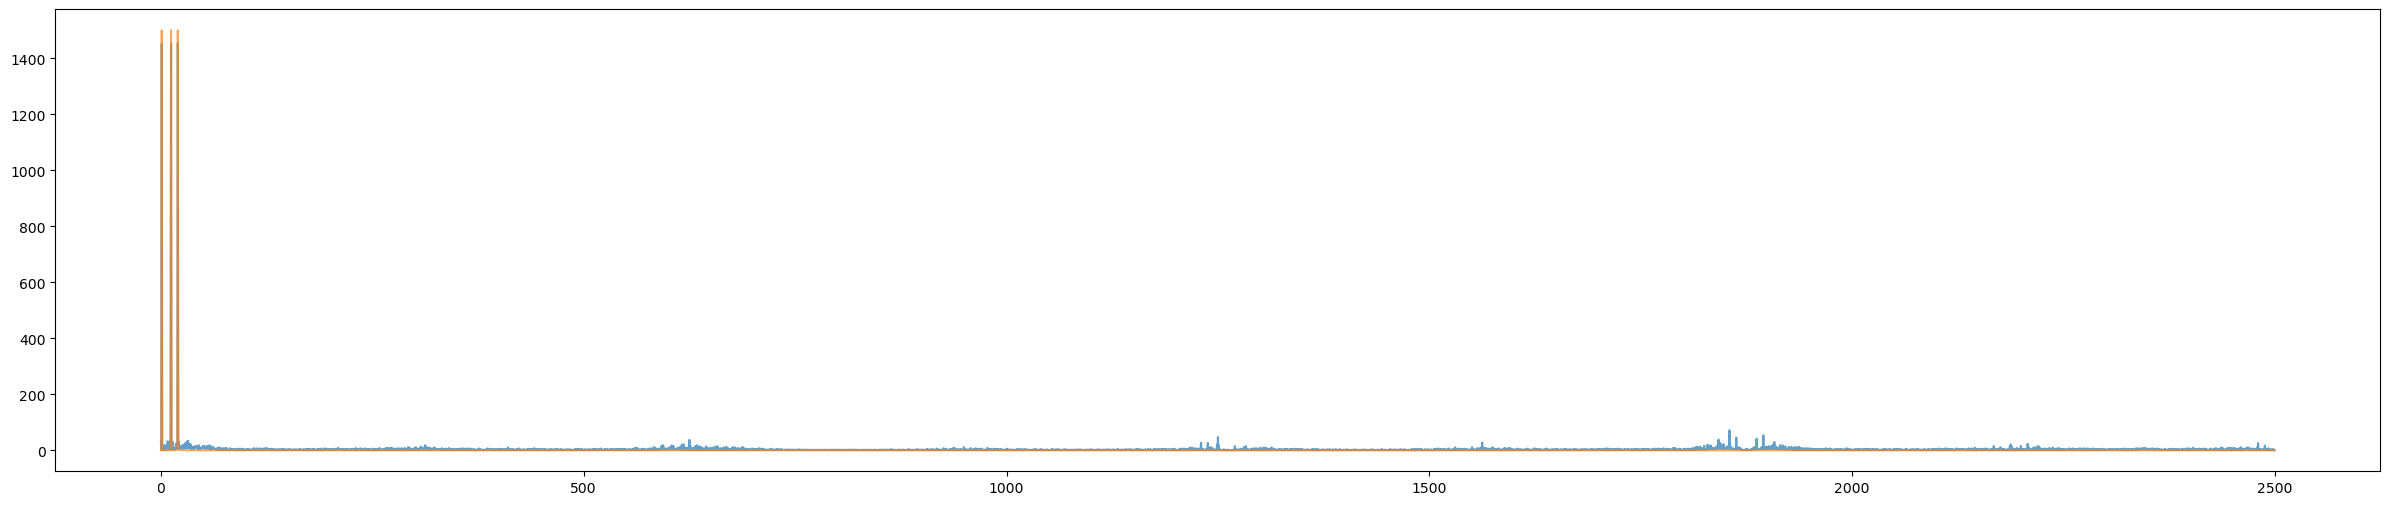

In [152]:
plt.figure(figsize=(30, 6))
iev = 4
d = 50
sampling_rate = outputs[iev].shape[0]
y = outputs[iev].detach()
y_fft1 = torch.fft.fft(y)
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate)
print(frequencies1[torch.argmax(torch.abs(y_fft1[:len(y_fft1)//2])).item()])

plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(y_fft1[:len(y_fft1)//2]).numpy(), label=f"channel {channel}", alpha=0.7)

y = labels[iev].detach()
y_fft1 = torch.fft.fft(y)
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(y_fft1[:len(y_fft1)//2]).numpy(), label=f"channel {channel}", alpha=0.7)


print(frequencies1[torch.argmax(torch.abs(y_fft1[:len(y_fft1)//2])).item()])

torch.Size([2000])
torch.Size([2000])


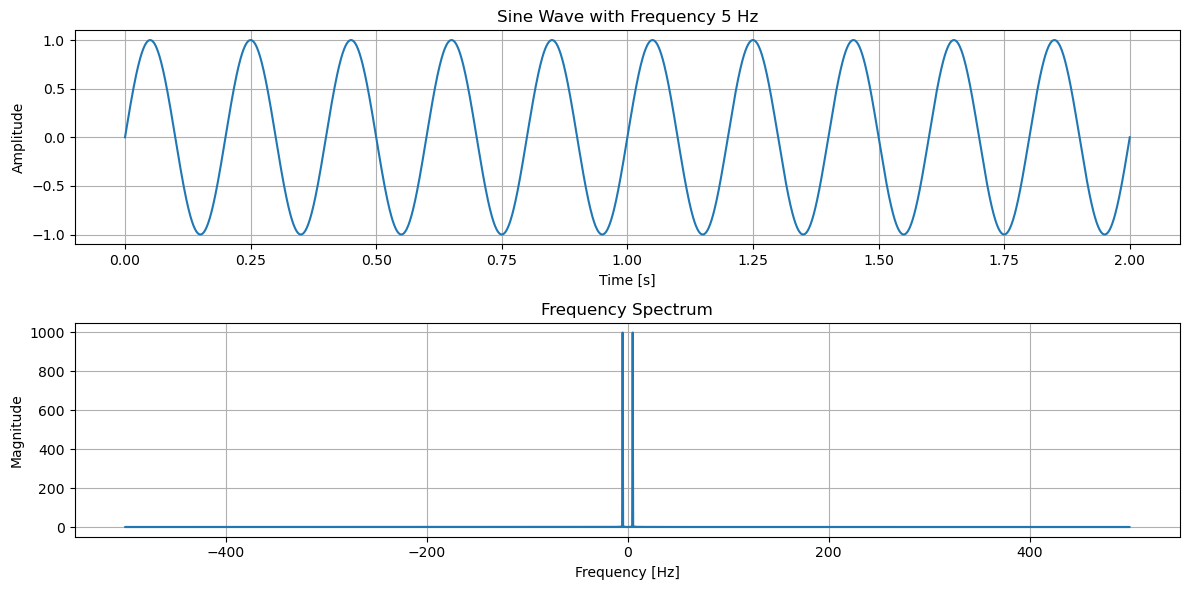

In [138]:
import torch
import matplotlib.pyplot as plt

# Parameters for the sine wave
sampling_rate = 1000  # Samples per second
duration = 2  # Duration in seconds
frequency = 5  # Frequency of the sine wave in Hz

# Create the time vector
t = torch.linspace(0, duration, int(sampling_rate * duration))

# Generate a sine wave
sine_wave = torch.sin(2 * torch.pi * frequency * t)

# Perform FFT
fft_result = torch.fft.fft(sine_wave)
print(fft_result.shape)
# Get the frequency axis
freqs = torch.fft.fftfreq(len(t), 1/sampling_rate)
print(freqs.shape)
# Compute the magnitude of the FFT (real part)
fft_magnitude = torch.abs(fft_result)

# Plot the sine wave
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t.numpy(), sine_wave.numpy())
plt.title(f"Sine Wave with Frequency {frequency} Hz")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot the FFT result (frequency domain)
plt.subplot(2, 1, 2)
plt.plot(freqs.numpy(), fft_magnitude.numpy())
plt.title("Frequency Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


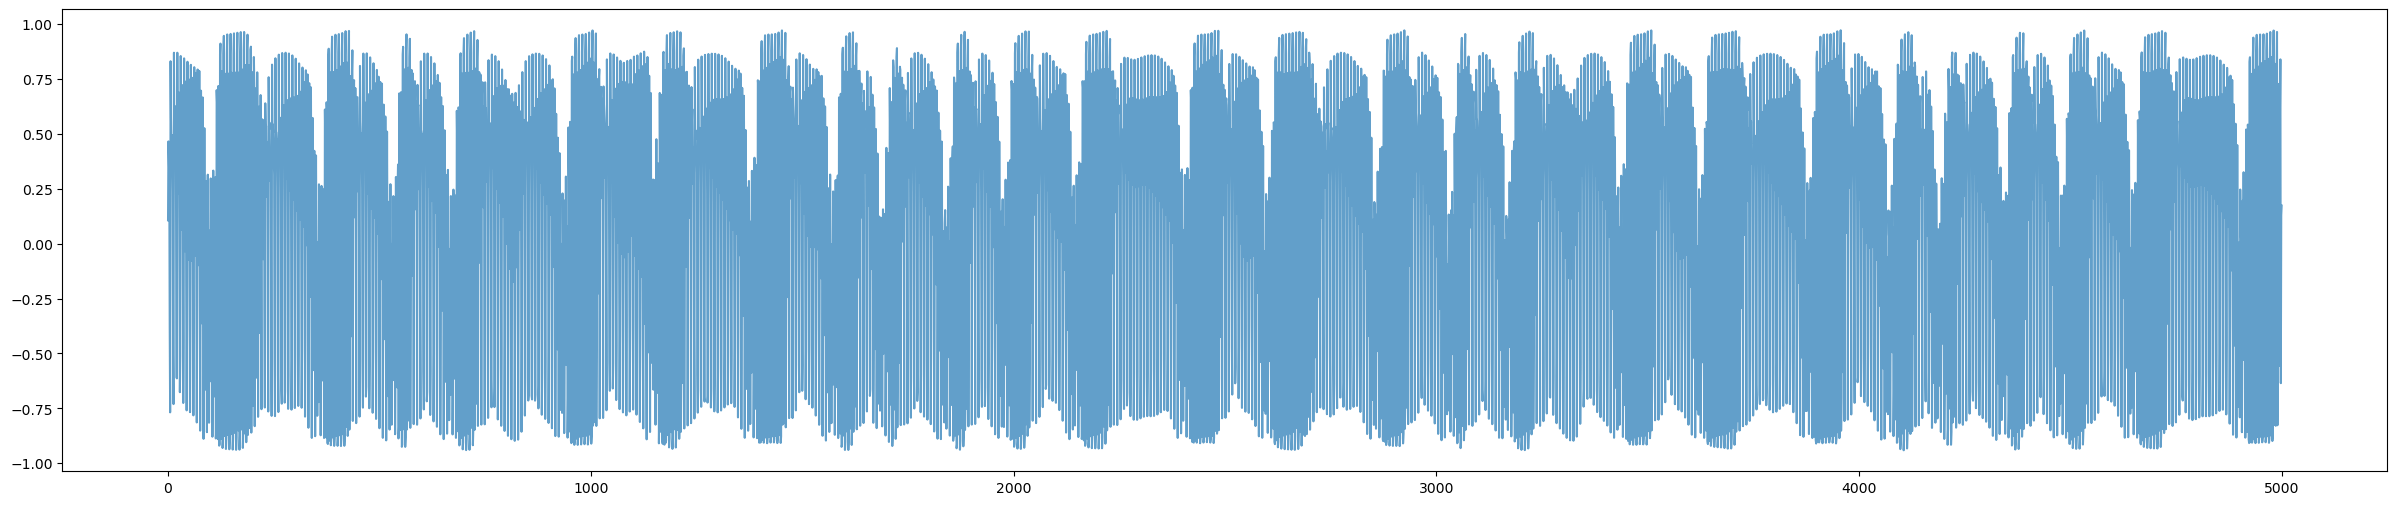

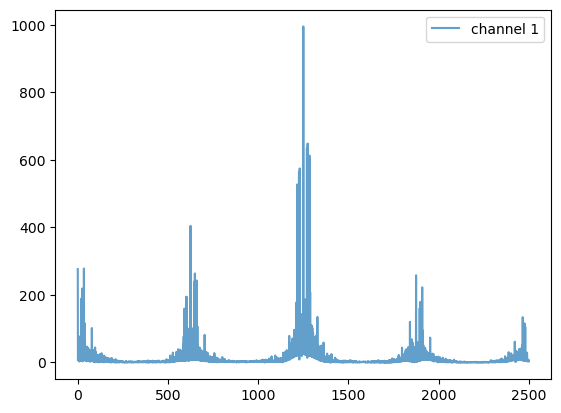

In [216]:
# plt.plot(data_for_viz[0]["downsample"][0][0])
# plt.plot(data_for_viz[0]["downsample"][0][1])
# plt.plot(data_for_viz[0]["downsample"][0][2])
epoch = 30
downsample_layer1 = "CONVTRANS_1"
downsample_layer2 = "CONVTRANS_2"
downsample_layer3 = "CONVTRANS_3"
iev = 4
channel = 1
channel2 = 1
channel3 = 1
plt.figure(figsize=(30, 6))
# plt.plot(data_for_viz[epoch][f"upsample_{downsample_layer1}"][iev][channel], alpha=0.7)
# plt.plot(data_for_viz[epoch][f"upsample_{downsample_layer2}"][iev][channel2], alpha=0.7)
plt.plot(data_for_viz[epoch][f"upsample_{downsample_layer3}"][iev][channel], alpha=0.7)
plt.show()

# plt.figure(figsize=(30, 6))
# sampling_rate = data_for_viz[epoch][f"upsample_{downsample_layer1}"][iev][channel].shape[0]
# y = torch.tensor(data_for_viz[epoch][f"upsample_{downsample_layer1}"][iev][channel])
# y_fft1 = torch.fft.fft(y)
# frequencies1 = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)
# plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(y_fft1[:len(y_fft1)//2]).numpy(), label=f"channel {channel}", alpha=0.7)

# sampling_rate = data_for_viz[epoch][f"upsample_{downsample_layer2}"][iev][channel].shape[0]
# y = torch.tensor(data_for_viz[epoch][f"upsample_{downsample_layer2}"][iev][channel])
# y_fft2 = torch.fft.fft(y)
# frequencies2 = torch.fft.fftfreq(len(y), d=1/sample_rate)
# plt.plot(frequencies2[:len(frequencies2)//2].numpy(), torch.abs(y_fft2[:len(y_fft2)//2]).numpy(), label=f"channel {channel2}", alpha=0.7)


sampling_rate = data_for_viz[epoch][f"upsample_{downsample_layer3}"][iev][channel3].shape[0]
y = torch.tensor(data_for_viz[epoch][f"upsample_{downsample_layer3}"][iev][channel3])
y_fft3 = torch.fft.fft(y)
frequencies3 = torch.fft.fftfreq(len(y), d=1/sample_rate)
plt.plot(frequencies3[:len(frequencies3)//2].numpy(), torch.abs(y_fft3[:len(y_fft3)//2]).numpy(), label=f"channel {channel3}", alpha=0.7)
plt.legend()
plt.show()



torch.Size([1250])
tensor(1250)


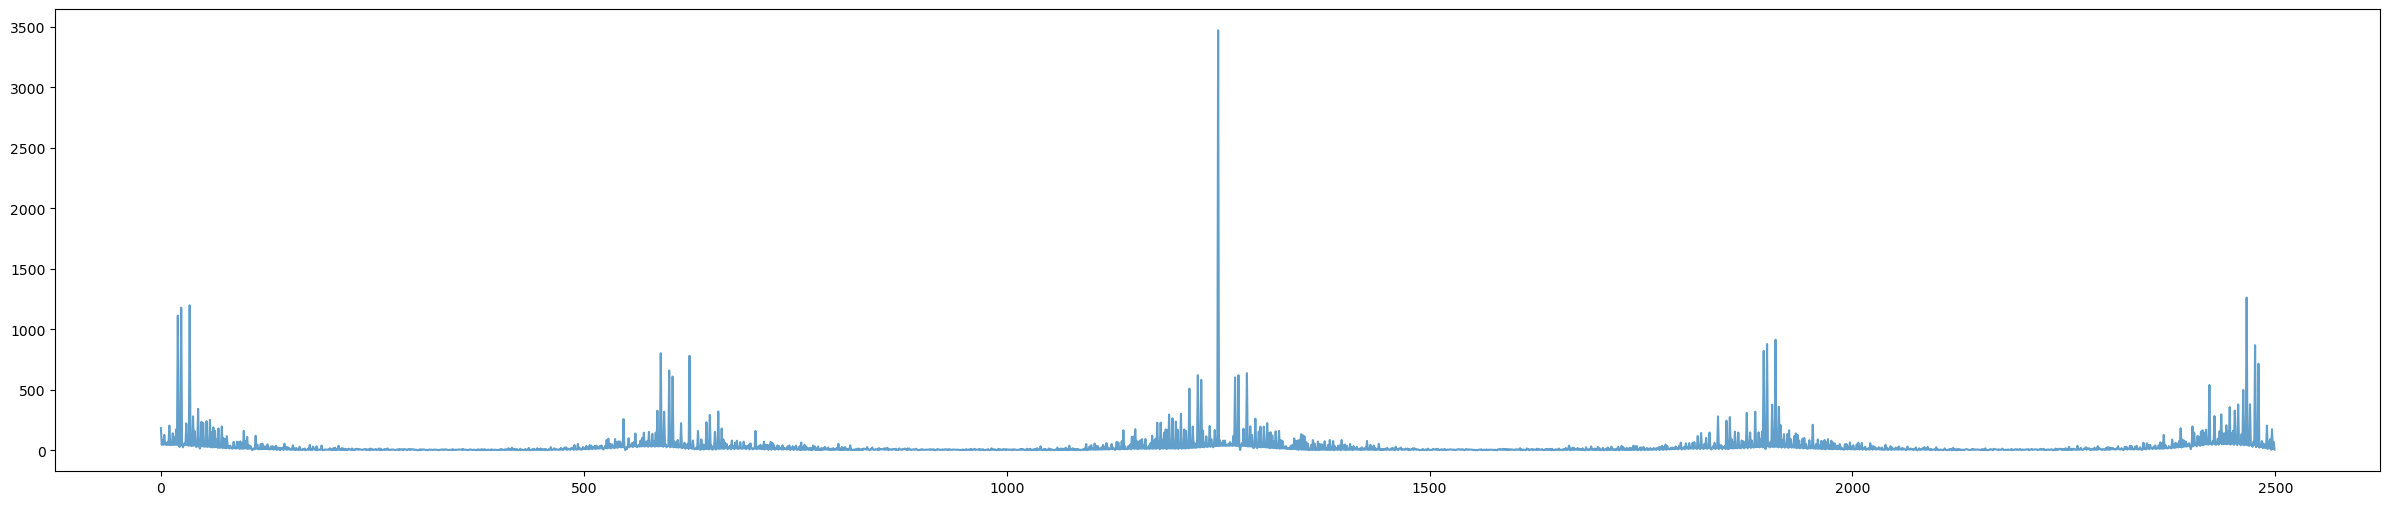

In [221]:
plt.figure(figsize=(30, 6))
sampling_rate = data_for_viz[epoch][f"upsample_{downsample_layer1}"][iev][channel].shape[0]
y = torch.tensor(data_for_viz[epoch][f"upsample_{downsample_layer1}"][iev][channel])
y_fft1 = torch.fft.fft(y)
frequencies1 = torch.fft.fftfreq(sampling_rate, d=1/sampling_rate)
print(y_fft1.shape)

upsample_layer3 = "CONVTRANS_3"
total_freq = None
for i in range(8):
    y = torch.tensor(data_for_viz[epoch][f"upsample_{upsample_layer3}"][iev][i])
    if total_freq is None:
        total_freq = torch.fft.fft(y)
    else:
        total_freq += torch.fft.fft(y)
        
sampling_rate = data_for_viz[epoch][f"upsample_{upsample_layer3}"][iev][channel].shape[0]
frequencies1 = torch.fft.fftfreq(len(y), d=1/sample_rate)

plt.plot(frequencies1[:len(frequencies1)//2].numpy(), torch.abs(total_freq[:len(total_freq)//2]).numpy(), label=f"channel {channel}", alpha=0.7)

print(torch.argmax(torch.abs(total_freq[:len(total_freq)//2])))

In [219]:
model.encodings["output_conv"].shape

(16, 1, 10000)

# Visualize weight matrices

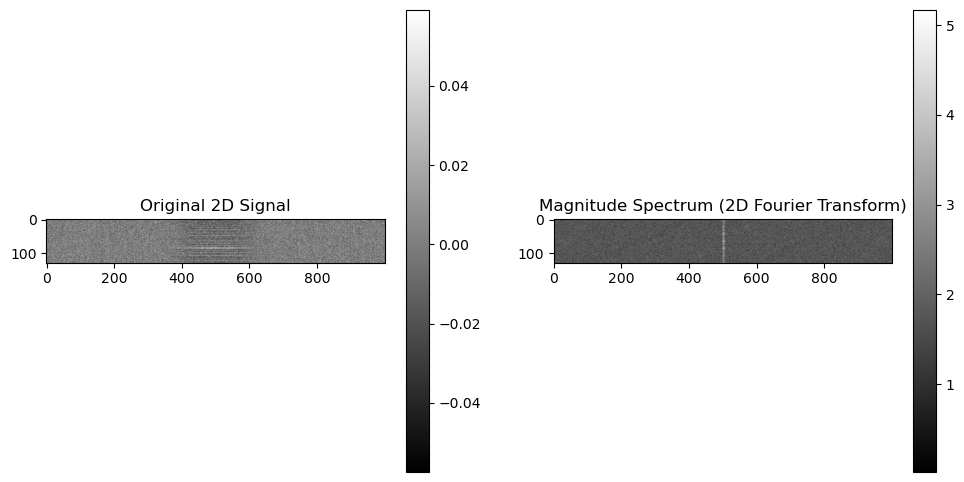

In [53]:
# 2D Fourier Transform

weight = model.fc1.weight.detach().numpy()

# Compute the 2D Fourier Transform
Z_ft = np.fft.fft2(weight)

# Shift the zero frequency component to the center of the spectrum
Z_ft_shifted = np.fft.fftshift(Z_ft)

# Compute the magnitude spectrum (absolute value) for visualization
magnitude_spectrum = np.abs(Z_ft_shifted)

# Plot the original 2D signal and its magnitude spectrum
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(weight, cmap='gray')
plt.title('Original 2D Signal')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log(magnitude_spectrum + 1), cmap='gray')  # Log scale for better visibility
plt.title('Magnitude Spectrum (2D Fourier Transform)')
plt.colorbar()

plt.show()

In [54]:
print(np.average(np.abs(Z_ft_shifted)[0]))
print(np.max(np.abs(Z_ft_shifted)[0]))

5.635796776548283
17.162746358527944


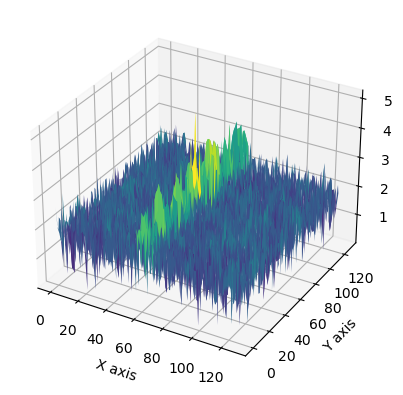

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

magnitude_spectrum_temp = magnitude_spectrum[:, 440:568]
# magnitude_spectrum_temp = magnitude_spectrum

# Create x and y coordinates
x = np.arange(magnitude_spectrum_temp.shape[0])
y = np.arange(magnitude_spectrum_temp.shape[1])

# Create a meshgrid (for X and Y coordinates)
X, Y = np.meshgrid(x, y)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, np.log(magnitude_spectrum_temp + 1), cmap='viridis')

# Labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis (Matrix Values)')

# Show the plot
plt.show()

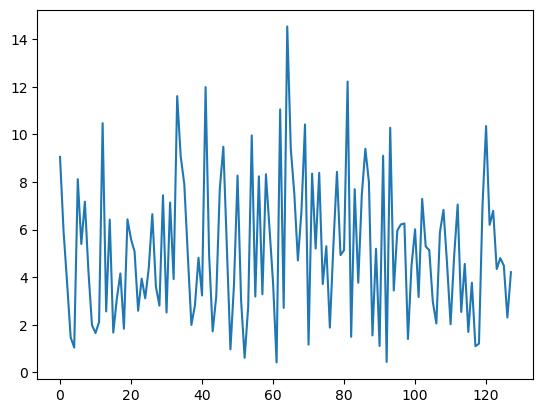

In [60]:
plt.plot(magnitude_spectrum[:,2])

In [58]:
magnitude_spectrum.shape

(128, 1000)

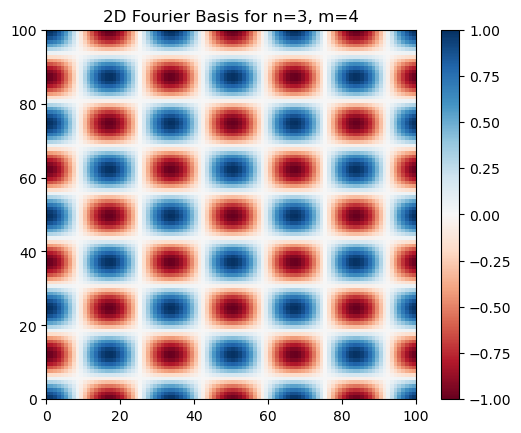

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Function to construct the 2D Fourier basis
def fourier_basis_2d(n, m, N):
    """
    Create a 2D Fourier basis function.
    
    Args:
        n (int): Frequency in x-direction.
        m (int): Frequency in y-direction.
        N (int): Size of the grid (NxN).
        
    Returns:
        2D numpy array representing the Fourier basis.
    """
    x = np.arange(N)
    y = np.arange(N)
    
    # Create a 2D grid
    X, Y = np.meshgrid(x, y)
    
    # 2D Fourier basis function: cos(nx) * cos(my)
    basis_function = np.cos(2 * np.pi * n * X / N) * np.cos(2 * np.pi * m * Y / N)
    
    return basis_function

# Set parameters
N = 100  # Grid size
n, m = 3, 4  # Frequencies in x and y directions

# Generate the Fourier basis
basis = fourier_basis_2d(n, m, N)

# Plot the 2D Fourier basis
plt.imshow(basis, extent=[0, N, 0, N], cmap='RdBu')
plt.colorbar()
plt.title(f"2D Fourier Basis for n={n}, m={m}")
plt.show()


In [ ]:
# mlp learns gaussian
# mlp doesn't learn noise
    
# work on colored noise and see weight matrix change, also change activation to nonelinear(tanh)
# monitor weight matrix change in frequency space

# 

In [4]:
import torch
x = torch.rand(10)

In [6]:
x = torch.linspace(0, 2 * torch.pi, steps=100)
y = torch.sin(x)

torch.fft.fft(y)

tensor([-2.9802e-08+0.0000e+00j,  1.5624e+00-4.9716e+01j,
        -4.2585e-02+6.7687e-01j, -3.5780e-02+3.7850e-01j,
        -3.3883e-02+2.6822e-01j, -3.3073e-02+2.0881e-01j,
        -3.2648e-02+1.7115e-01j, -3.2396e-02+1.4494e-01j,
        -3.2236e-02+1.2555e-01j, -3.2127e-02+1.1058e-01j,
        -3.2049e-02+9.8641e-02j, -3.1992e-02+8.8863e-02j,
        -3.1949e-02+8.0696e-02j, -3.1916e-02+7.3753e-02j,
        -3.1890e-02+6.7768e-02j, -3.1868e-02+6.2545e-02j,
        -3.1850e-02+5.7935e-02j, -3.1836e-02+5.3832e-02j,
        -3.1824e-02+5.0145e-02j, -3.1813e-02+4.6811e-02j,
        -3.1805e-02+4.3775e-02j, -3.1796e-02+4.0993e-02j,
        -3.1790e-02+3.8429e-02j, -3.1785e-02+3.6054e-02j,
        -3.1780e-02+3.3843e-02j, -3.1776e-02+3.1776e-02j,
        -3.1774e-02+2.9837e-02j, -3.1769e-02+2.8008e-02j,
        -3.1766e-02+2.6279e-02j, -3.1763e-02+2.4637e-02j,
        -3.1760e-02+2.3075e-02j, -3.1759e-02+2.1584e-02j,
        -3.1756e-02+2.0153e-02j, -3.1755e-02+1.8780e-02j,
        -3.175

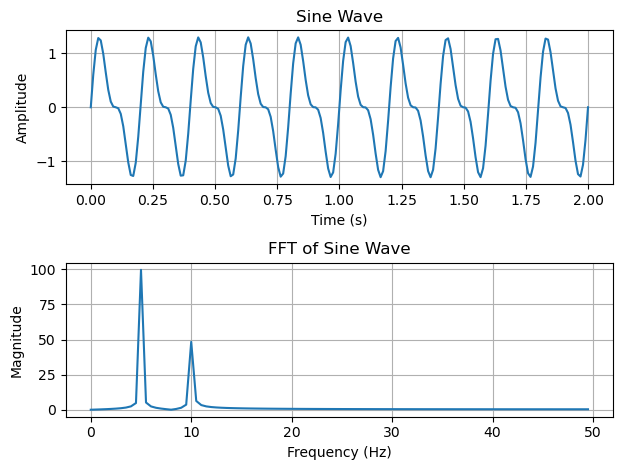

In [14]:
import torch
import matplotlib.pyplot as plt

# Parameters for the sine wave
frequency = 5  # Frequency in Hz
frequency2 = 10
sampling_rate = 100  # Sampling rate in Hz
duration = 2  # Duration in seconds

# Generate time steps
t = torch.linspace(0, duration, int(sampling_rate * duration))

# Generate the sine wave: y(t) = sin(2 * pi * f * t)
y = torch.sin(2 * torch.pi * frequency * t) + 1/2*torch.sin(2 * torch.pi * frequency2 * t)

# Compute the FFT of the sine wave
y_fft = torch.fft.fft(y)

# Compute the frequencies corresponding to the FFT values
frequencies = torch.fft.fftfreq(len(t), d=1/sampling_rate)

# Plot the sine wave
plt.subplot(2, 1, 1)
plt.plot(t.numpy(), y.numpy())
plt.title("Sine Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot the FFT (magnitude spectrum)
plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2].numpy(), torch.abs(y_fft[:len(y_fft)//2]).numpy())
plt.title("FFT of Sine Wave")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
frequencies.shape

torch.Size([200])

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import irfft

def normalize(x):
    return (x - np.mean(x)) / np.std(x)

def white(N, state=None):
    state = np.random.RandomState() if state is None else state
    return state.randn(N)

def pink(N, state=None):
    state = np.random.RandomState() if state is None else state
    uneven = N % 2
    X = state.randn(N // 2 + 1 + uneven) + 1j * state.randn(N // 2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)
    y = (irfft(X / S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)


def blue(N, state=None):
    state = np.random.RandomState() if state is None else state
    uneven = N % 2
    X = state.randn(N // 2 + 1 + uneven) + 1j * state.randn(N // 2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)))  # Filter
    y = (irfft(X * S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)


def violet(N, state=None):
    state = np.random.RandomState() if state is None else state
    uneven = N % 2
    X = state.randn(N // 2 + 1 + uneven) + 1j * state.randn(N // 2 + 1 + uneven)
    S = (np.arange(len(X)))  # Filter
    y = (irfft(X * S)).real
    if uneven:
        y = y[:-1]
    return normalize(y)


def add_noise_to_signal(signal, noise_type, noise_level=1.0, sr=10000):
    N = len(signal)
    if noise_type == 'white':
        noise = white(N, state=None) * noise_level
    elif noise_type == 'pink':
        noise = pink(N, state=None) * noise_level
    elif noise_type == 'blue':
        noise = blue(N, state=None) * noise_level
    elif noise_type == 'violet':
        noise = violet(N, state=None) * noise_level
    else:
        raise ValueError("Unsupported noise type")
    
    return signal + noise, noise


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def build_empty_signal(n, sr):
    t = np.arange(n) / sr
    x = np.zeros(n)
    return x, t

def gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    signal_length = len(x)
    
    for _ in range(num_pulses):
        std = np.random.uniform(std_min, std_max)
        amp = np.random.uniform(amp_min, amp_max)
        
        window_length = int(2 * std_length * std)  # Ensure the window length is odd
        if window_length % 2 == 1: window_length -= 1
                
        window = signal.windows.gaussian(window_length, std=std)
        window = amp*window
        
        
        pos = np.random.randint(window_length, signal_length-window_length//2)
        
        start = pos - (window_length // 2) 
        end = pos + (window_length // 2 )
        
        
        window_segment = window[:end - start]  # Adjust the length of the window segment
        x[start:end] += window_segment

        '''
        plt.figure(figsize=(12, 6))
        plt.plot(t, x)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Signal with Gaussian Pulses')
        plt.grid(True)
        plt.show()
        '''

    return x


def gauss_sig_bipolar(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length):
    signal_length = len(x)
    
    for _ in range(num_pulses):
        std = np.random.uniform(std_min, std_max)
        amp = np.random.uniform(amp_min, amp_max)
        
        window_length = int(2 * std_length * std)  # Ensure the window length is odd
        window_length = min(window_length, signal_length)  # Ensure window length does not exceed signal length
        
        window = signal.windows.gaussian(window_length, std=std)
        window = amp * window
        
        # Alternate the sign to make it bipolar
        window = window * (-1) ** (np.arange(window_length) // (window_length // 2))
        
        # Random position for the center of the pulse
        pos = np.random.randint(window_length // 2, signal_length - window_length // 2)
        
        # Define the start and end indices for placing the window
        start = pos - (window_length // 2)
        end = pos + (window_length // 2) 
        
        # Add the window to the signal, handling boundary conditions
        x[start:end] += window[:end - start]
    
    return x



def sin_mod_base(x, t, c_freq, mod_index):
    carrier = np.sin(2 * np.pi * carrier_freq * t)
    #prevent distortion
    mod_index = min(mod_index, 1 / np.max(np.abs(x)))
    mod_x = (1 + mod_index * x) * carrier
    return mod_x


def main():
    # Parameters
    n = 10000
    sr = 10000
    std_min = 50
    std_max = 200
    amp_min = 1
    amp_max = 20
    num_pulses = 3
    std_length = 3
    c_freq = 100
    m_index = 1

    # Build the signal
    x, t = build_empty_signal(n, sr)
    x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)

    # Modulate the signal
    modulated_signal = sin_mod_base(x, t, c_freq, m_index)

    # Plot the modulated signal
    plt.figure(figsize=(12, 6))
    plt.plot(t, modulated_signal, label='Modulated Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Modulated Signal')
    plt.grid(True)
    plt.legend()
    plt.show()



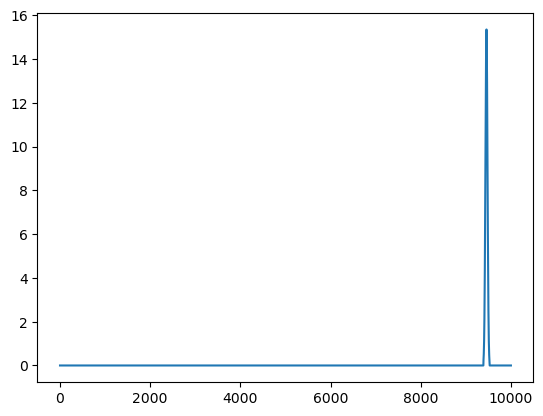

In [19]:
n = 10000
sr = 10000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3
c_freq = 100
m_index = 1
use_model = "deepclean"

# Build the signal
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)
plt.show()
x_noised, noise = add_noise_to_signal(x, "pink", sr=sr)

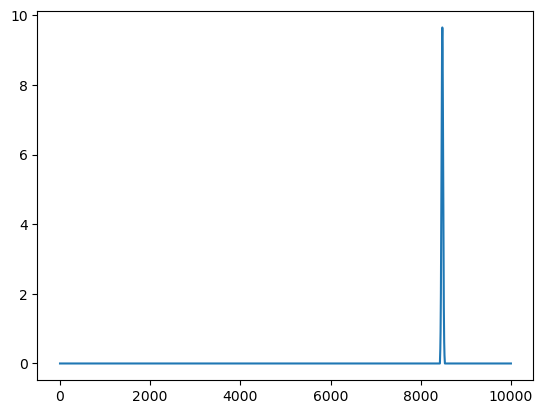

In [28]:
n = 10000
sr = 10000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3
c_freq = 100
m_index = 1
use_model = "deepclean"

# Build the signal
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)
plt.show()
x_noised, noise = add_noise_to_signal(x, "pink", sr=sr)
x = torch.tensor(x)
y_fft = torch.fft.fft(x)
sampling_rate = 100
# Compute the frequencies corresponding to the FFT values
frequencies = torch.fft.fftfreq(len(x), d=1/sampling_rate)
# gaussian_fft_shifted = torch.fft.fftshift(y_fft)

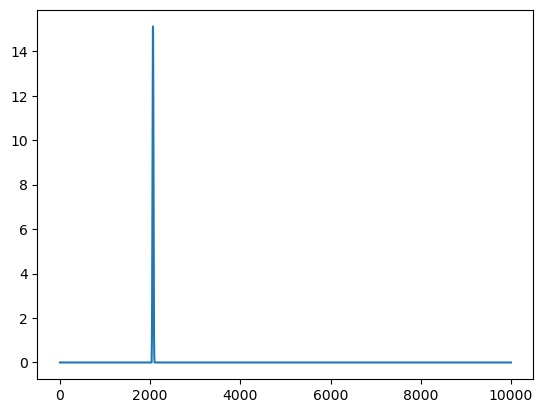

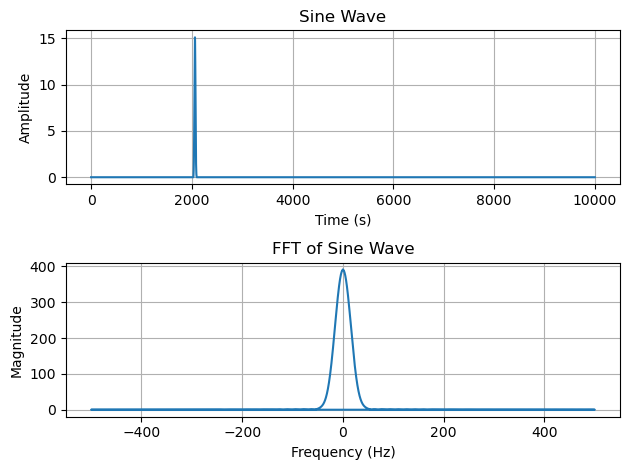

In [38]:
n = 10000
sr = 10000
std_min = 10
std_max = 30
amp_min = 1
amp_max = 20
num_pulses = 1
std_length = 3
c_freq = 100
m_index = 1
use_model = "deepclean"

# Build the signal
x, t = build_empty_signal(n, sr)
x = gauss_sig(x, t, std_min, std_max, amp_min, amp_max, num_pulses, std_length)
plt.plot(x)
plt.show()
x_noised, noise = add_noise_to_signal(x, "pink", sr=sr)

x = torch.tensor(x)
y_fft = torch.fft.fft(x)
sampling_rate = 100
# Compute the frequencies corresponding to the FFT values
frequencies = torch.fft.fftfreq(len(x), d=0.001)
# gaussian_fft_shifted = torch.fft.fftshift(y_fft)

plt.subplot(2, 1, 1)
plt.plot(x.detach().numpy())
plt.title("Sine Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot the FFT (magnitude spectrum)
plt.subplot(2, 1, 2)
plt.plot(frequencies.numpy(), torch.abs(y_fft).numpy())
plt.title("FFT of Sine Wave")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()

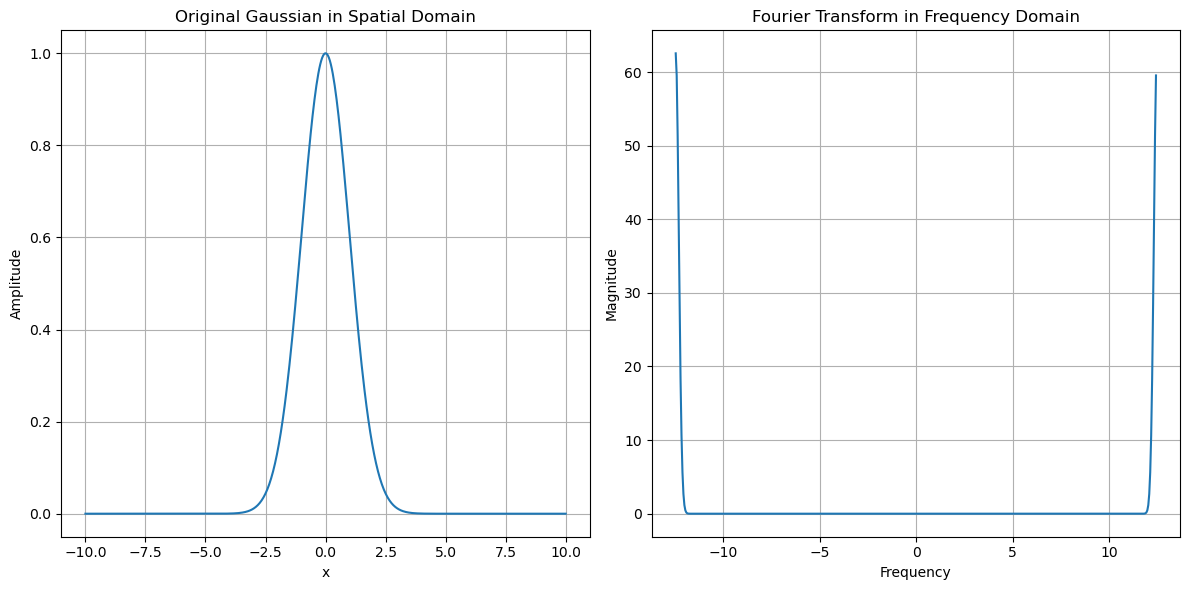

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define parameters for the Gaussian function
mean = 0.0
sigma = 1.0
num_points = 500
x = torch.linspace(-10, 10, num_points)

# Create the Gaussian function
gaussian = torch.exp(-(x - mean)**2 / (2 * sigma**2))

# Perform the Fourier Transform
gaussian_fft = torch.fft.fft(gaussian)

# Shift the zero frequency component to the center
# gaussian_fft_shifted = torch.fft.fftshift(gaussian_fft)

# Get the absolute value and real part of the Fourier-transformed Gaussian for visualization
gaussian_fft_magnitude = torch.abs(gaussian_fft)
gaussian_fft_real = torch.real(gaussian_fft_shifted)

# Define frequency axis (for plotting)
freq = torch.fft.fftfreq(num_points, d=(x[1] - x[0])).numpy()
freq_shifted = np.fft.fftshift(freq)

# Plot the original Gaussian
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x.numpy(), gaussian.numpy(), label="Original Gaussian")
plt.title("Original Gaussian in Spatial Domain")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot the Fourier transform (magnitude)
plt.subplot(1, 2, 2)
plt.plot(freq_shifted, gaussian_fft_magnitude.numpy(), label="Fourier Transform (Magnitude)")
plt.title("Fourier Transform in Frequency Domain")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()
